# Light GBM Model



In [1]:
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
import sklearn
from Functions import prepro
import warnings
warnings.filterwarnings('ignore')

import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
warnings.filterwarnings('ignore')
import lightgbm as lgb
from lightgbm import LGBMClassifier


FEATURE_SELECTION = False
tgt_encode = False

random.seed(0)

pd.set_option("display.max_columns", 700)
pd.set_option("display.max_rows", 700)


In [2]:
train_df = pd.read_csv("../../data/Processed/train2.csv")
test_df = pd.read_csv("../../data/Processed/test2.csv")
print(train_df.shape)
print(test_df.shape)

(66125, 304)
(28340, 303)


In [3]:
y = train_df["y"].values
train_df = train_df.drop("y", axis=1)

In [5]:
# add disconnection info

train_df = prepro.add_disconnection(train_df)
test_df = prepro.add_disconnection(test_df)

In [6]:
# add info about numeric column
# 武器データの中のnum_colsを持つ特徴について、チーム内の統計量を計算、levelは結構効いてる

# num_cols = ["level", "range", "rapid", "atack", "ink-sub", "fav-main", "good-special"]

num_cols = [
    "level", "range-main", "range-bullet-main", "range-draw-main", "direct_range-sub", "distant-range_sub", 
    "rapid", "atack", "ink-sub", "fav-main", "good-special", "DPS", "kill_time_human-main", "kill_time_ika-main",
    "front_gap_human-main", "front_gap_ika-main", "rensya_frame-main", "saidai_damege-main", "damage_min-sub", 
    "damage_max-sub", "install_num-sub", "good-sub", "direct_range-sub", "distant-range_sub", "damage_max-special", 
    "damage_min-special", "duration-special", "good-special", "direct_rad-special", "close_rad-special", "distant_rad-special"
]

#train_df = prepro.flat(train_df, num_cols)
#test_df = prepro.flat(test_df, num_cols)

train_df = prepro.add_numeric_info(train_df, num_cols)
test_df = prepro.add_numeric_info(test_df, num_cols)

# 欠損値埋め先にやろう
欠損値がある列

rank, weapon, level ⇨　回線切れ or ナワバリ

weaponの欠損に並んでそれに関係ある列、A3, A4, B3, B4 ⇨ 回線切れ

level, weaponが消えていたら回線切れ

In [7]:
# rankの欠損値を埋める
train_df, test_df = prepro.fillna_rank(train_df, test_df)

#そのほかの欠損値を埋める
train_df, test_df = prepro.fillna(train_df, test_df)

In [8]:
print(train_df.isnull().sum().sum())
print(test_df.isnull().sum().sum())

0
0


# 特徴量エンジニアリング


In [9]:
# count reskin, by mode
print("reskin")
train_df, test_df = prepro.count_reskin(train_df, test_df)
train_df, test_df = prepro.count_reskin_by_mode(train_df, test_df)

# count mainweapon, by mode
print("mainweapon")
train_df, test_df = prepro.count_mainweapon(train_df, test_df)
train_df, test_df = prepro.count_mainweapon_by_mode(train_df, test_df)

# count subweapon, by mode
print("subweapon")
train_df, test_df = prepro.count_subweapon(train_df, test_df)
train_df, test_df = prepro.count_subweapon_by_mode(train_df, test_df)

# count special, by mode
print("special")
train_df, test_df = prepro.count_special(train_df, test_df)
train_df, test_df = prepro.count_special_by_mode(train_df, test_df)

# level inverse
#train_df, test_df = prepro.level_inverse(train_df, test_df)
#train_df = prepro.add_numeric_info(train_df, ["level-inverse"])
#test_df = prepro.add_numeric_info(test_df, ["level-inverse"])

#identify A1
train_df, test_df = prepro.identify_A1(train_df, test_df)


# 水増し, A1も統計量に含めた特徴を作る場合は水ましより先にやる
print("mizumashi")
train_df, y = prepro.mizumashi(train_df, y)

# is_nawabari
train_df, test_df = prepro.is_nawabari(train_df, test_df)

# match rank
train_df, test_df = prepro.match_rank(train_df, test_df)



reskin
mainweapon
subweapon
special
mizumashi


In [10]:
# add team info

train_df,  test_df = prepro.addTeamInfo(train_df, test_df, cols=["special", "subweapon", "category1", "category2", "mainweapon"])

(160590, 708)
special-A
special-B
subweapon-A
subweapon-B
category1-A
category1-B
category2-A
category2-B
mainweapon-A
mainweapon-B
(160590, 902)
complete


In [11]:
# categorize team , 良い

categorize_col = ["category1", "category2", "subweapon", "special", "mainweapon"]
for col in categorize_col:
    print(col)
    train_df, test_df = prepro.categorize_team(train_df, test_df, col)

category1
category2
subweapon
special
mainweapon


In [12]:
# product categorical feature
train_df, test_df = prepro.prod(train_df, test_df, "mode", "stage")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-category1-A")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-category1-B")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-category2-A")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-category2-B")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-mainweapon-A")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-mainweapon-B")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-subweapon-A")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-subweapon-B")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-special-A")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-special-B")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "match_rank")

train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-category1-A")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-category1-B")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-category2-A")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-category2-B")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-mainweapon-A")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-mainweapon-B")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-subweapon-A")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-subweapon-B")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-special-A")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-special-B")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "match_rank")


train_df, test_df = prepro.prod(train_df, test_df, "mode", "reskin-A1")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "reskin-A2")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "reskin-A3")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "reskin-A4")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "reskin-B1")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "reskin-B2")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "reskin-B3")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "reskin-B4")

In [13]:
# make input

drop_cols = ["id", "lobby", "lobby-mode",  "period", "game-ver", "A1-weapon", "A2-weapon", "A3-weapon", "A4-weapon", \
              "B1-weapon", "B2-weapon", "B3-weapon", "B4-weapon"]

categorical_feature = [col for col in train_df.dtypes[train_df.dtypes == "object"].index.to_list() if col not in drop_cols]

X, test_X = prepro.make_input(train_df, test_df, drop_cols, categorical_encode=True, scaler=False, verbose=False)

complete


In [14]:
print(X.shape)
print(test_X.shape)

(132250, 930)
(28340, 930)


# 特徴選択
gbdtは内部で特徴選択を行うのでおそらく使用しないほうがいい

In [15]:
if FEATURE_SELECTION:
    from sklearn.ensemble import RandomForestClassifier

    clf = RandomForestClassifier()
    clf.fit(X, y)
    importance = pd.DataFrame(clf.feature_importances_, index=X.columns, columns=['importance']).sort_values('importance', ascending=False)
    display(importance*10000)
    use_cols = importance.index[:450]
else:
    print("No feature selection")


No feature selection


In [16]:
cat_tgtenc_cols = [
    "mode", "stage", "team-category1-A", "team-category1-B", "team-category2-A", "team-category2-B",
    "team-subweapon-A", "team-subweapon-B", "team-special-A", "team-special-B", "mode x team-category1-A", "mode x team-category1-B"
]
for col in cat_tgtenc_cols:
    print(train_df[col].unique().shape[0], col)

5 mode
23 stage
138 team-category1-A
138 team-category1-B
735 team-category2-A
735 team-category2-B
1853 team-subweapon-A
1853 team-subweapon-B
2588 team-special-A
2588 team-special-B
515 mode x team-category1-A
515 mode x team-category1-B


# モデル学習

In [17]:
# 全データを5つに分割
random.seed(random.randint(0, 10000))
SIZE = X.shape[0]
K = 5
cat_tgtenc_cols = [
    "team-category1-A", "team-category1-B", "team-category2-A", "team-category2-B",
    "team-subweapon-A", "team-subweapon-B", "team-special-A", "team-special-B"
]
cat_tgtenc_cols = [
    "mode x team-category1-A", "mode x team-category1-B", 
    "mode x reskin-A1", "mode x reskin-A2", "mode x reskin-A3", "mode x reskin-A4",
     "mode x reskin-B1", "mode x reskin-B2", "mode x reskin-B3", "mode x reskin-B4"
]

folds = prepro.make_stratified_kfolds(X, y, K, shuffle=True)
#folds = prepro.make_stratified_kfolds(X, X["mode"] + y.astype(str), K, shuffle=True)


print(len(folds))
for i, fold in enumerate(folds):
    print("fold ", i+1, " size is ", len(fold))
    
    
if SIZE != len(set(sum(folds, []))):
    print("error is occuring in spliting")
else :
    print("successfully split")
    
if FEATURE_SELECTION:
    X = X[use_cols]
    test_X = test_X[use_cols]

5
fold  1  size is  26450
fold  2  size is  26450
fold  3  size is  26450
fold  4  size is  26450
fold  5  size is  26450
successfully split


In [18]:
param = {
    "num_leaves" : 28,
    "learning_rate" : 0.01,
    #"learning_rate" : 0.1,
    "num_iterations" : 20000,
    "objective" : "binary",
    "metric" : ["binary_logloss"],
    "random_state" : random.randint(0, 10000),
    #"random_state" : 0,
    "max_depth" : 100
}

THRESHOLD = 0.50
models = []
cv_scores = []
temp = 0
train_pred = []
train_Xs = []
valid_Xs = []


all_indices = sum(folds, [])
for i in range(K):
    print("======================== fold {} ========================".format(i+1))
    valid_indices = folds[i]
    train_indices = list(set(all_indices) - set(valid_indices))
    # print("train ", len(train_indices), " , valid ", len(valid_indices))
    train_X = X.iloc[train_indices]
    try:
        train_y = y.iloc[train_indices]
    except:
        train_y = y[train_indices]
    valid_X = X.iloc[valid_indices]
    try:
        valid_y = y.iloc[valid_indices]
    except:
        valid_y = y[valid_indices]
    
    
    if tgt_encode:
        for col in cat_tgtenc_cols:
            print(col)
            train_X, valid_X = prepro.target_encoder(train_X, valid_X, col, train_y)
        train_X = prepro.add_numeric_info(train_X, ["tgtenc-mode x reskin"])
        valid_X = prepro.add_numeric_info(valid_X, ["tgtenc-mode x reskin"])
        
    
    train_data = lgb.Dataset(train_X, label=train_y)
    valid_data = lgb.Dataset(valid_X, label=valid_y)
    train_Xs.append(train_X)
    valid_Xs.append(valid_X)
    
    model = lgb.train(
        param, 
        train_data, 
        valid_sets=valid_data, 
        #categorical_feature=categorical_feature,
        early_stopping_rounds=100, 
        verbose_eval=100,
        
    )
    pred = model.predict(valid_X)
    pred = np.where(pred < THRESHOLD, 0, 1)
    train_pred.append(pred)
    temp += np.sum(pred)
    
    score = accuracy_score(pred, valid_y)
    
    models.append(model)
    cv_scores.append(score)
    
    
print("cv score : ", np.mean(cv_scores))    
print("cv ratio : ", temp / SIZE)

======================== fold 1 ========================
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.68787
[200]	valid_0's binary_logloss: 0.685144
[300]	valid_0's binary_logloss: 0.683735
[400]	valid_0's binary_logloss: 0.682953
[500]	valid_0's binary_logloss: 0.682614
[600]	valid_0's binary_logloss: 0.682353
[700]	valid_0's binary_logloss: 0.682181
[800]	valid_0's binary_logloss: 0.682052
[900]	valid_0's binary_logloss: 0.681943
[1000]	valid_0's binary_logloss: 0.681844
[1100]	valid_0's binary_logloss: 0.681768
Early stopping, best iteration is:
[1102]	valid_0's binary_logloss: 0.681766
======================== fold 2 ========================
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.687825
[200]	valid_0's binary_logloss: 0.685097
[300]	valid_0's binary_logloss: 0.683639
[400]	valid_0's binary_logloss: 0.682891
[500]	valid_0's binary_logloss: 0.682427
[600]	valid_0's binary_logloss

0.5099537233750153
0.510315407744386
0.5105156850433463
0.5104266218523581
0.5107399888421132
0.5103902853714437


array([[<AxesSubplot:title={'center':'pred'}>]], dtype=object)

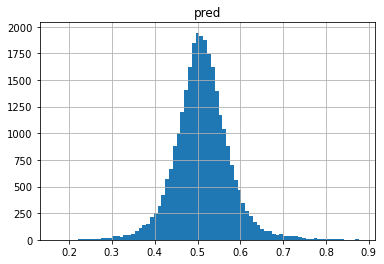

In [19]:
preds = []
if tgt_encode:
    for col in cat_tgtenc_cols:
        print(col)
        _, test_X_ = prepro.target_encoder(X, test_X, col, y)
        if col in test_X.columns:
            test_X = test_X.drop(col, axis=1)
    test_X = prepro.add_numeric_info(test_X, ["tgtenc-mode x reskin"])


        
for i in range(K):
    model = models[i]
    pred = model.predict(test_X)
    preds.append(pred)
    print(np.sum(pred) / pred.shape[0])
    
preds = np.array(preds)
preds = np.mean(preds, axis=0)
print(np.sum(preds) / preds.shape[0])


temp = pd.DataFrame({"pred":pred})
temp.hist(bins=80)

In [28]:
preds = np.where(preds < THRESHOLD, 0, 1)
print(np.sum(preds) / preds.shape[0])

submit_df = pd.DataFrame({'y': preds})
submit_df.index.name = 'id'
submit_df.to_csv('../Submissions/submission12_{}.csv'.format(K))

0.5754763585038815


# モデル解釈

In [21]:
importance = pd.DataFrame(models[0].feature_importance(), index=train_Xs[0].columns, columns=['importance']).sort_values('importance', ascending=False)
display(importance.iloc[:100])

,importance
A-level-median,607
B-level-median,508
A-level-max,291
B-level-mean,286
B1-level,280
A-level-min,267
A1-level,251
A4-level,241
B-level-sum,239
B-level-max,237


In [ ]:
indices = [index for index in importance.index if "tgtenc" in index]
importance.loc[indices]

In [ ]:
importance["importance"].sum()

In [ ]:
train_df["pred"] = 0
train_df["y"] = y
for i in range(K):
    train_df["pred"].iloc[folds[i]] = train_pred[i]
for mode in train_df["mode"].unique():
    rate = train_df[train_df["mode"] == mode][train_df["pred"] == train_df["y"]].shape[0] / train_df[train_df["mode"] == mode].shape[0]
    print("{} : {}".format(mode, rate))
print(train_df[train_df["pred"] == train_df["y"]].shape[0] / train_df.shape[0])

In [ ]:
result_df = train_df[train_df["y"] != train_df["pred"]]

In [ ]:
result_df.to_csv("../../data/result.csv", index=False)

In [ ]:
print(train_df[train_df["mode"] == "nawabari"].shape[0]/train_df.shape[0])
print(train_df[train_df["mode"] == "hoko"].shape[0]/train_df.shape[0])
print(train_df[train_df["mode"] == "asari"].shape[0]/train_df.shape[0])
print(train_df[train_df["mode"] == "area"].shape[0]/train_df.shape[0])
print(train_df[train_df["mode"] == "yagura"].shape[0]/train_df.shape[0])

In [ ]:
print(result_df[result_df["mode"] == "nawabari"].shape[0]/result_df.shape[0])
print(result_df[result_df["mode"] == "hoko"].shape[0]/result_df.shape[0])
print(result_df[result_df["mode"] == "asari"].shape[0]/result_df.shape[0])
print(result_df[result_df["mode"] == "area"].shape[0]/result_df.shape[0])
print(result_df[result_df["mode"] == "yagura"].shape[0]/result_df.shape[0])

In [ ]:
result_df.loc[:100]

In [ ]:
num_cols_ = [
    "range-main", "range-bullet-main", "range-draw-main", "direct_range-sub", "distant-range_sub", 
    "rapid", "atack", "ink-sub", "fav-main", "good-special", "DPS", "kill_time_human-main", "kill_time_ika-main",
    "front_gap_human-main", "front_gap_ika-main", "rensya_frame-main", "saidai_damege-main", "damage_min-sub", 
    "damage_max-sub", "install_num-sub", "good-sub", "direct_range-sub", "damage_max-special", 
    "damage_min-special", "duration-special", "good-special", "direct_rad-special", "close_rad-special", "distant_rad-special"
]


In [ ]:
feature_cols = []
for name in num_cols_:
    for col in X.columns:
        if name in col:
            feature_cols.append(col)
                
importance.loc[feature_cols]#.sort_values('importance', ascending=False)

In [ ]:
sss = []

"""
A-direct_range-sub-mean 30
A-distant_range_sub-max
B-rapid-std	52
ink-sub
A-kill_time_human-main-median	36
A-kill_time_ika-main-median	58
A-front_gap_human-main-std	25
A-front_gap_ika-main-std	48
A-saidai_damege-main-mean	40
damage_max-sub 37
install_num-sub 10
direct_range-sub 30
damage_max-special 47
duration-special 46
close_rad-special 30
distant_rad-special 21
"""




for col in X.columns:
    if "distant_rad-special" in col:
        sss.append(col)
                
importance.loc[sss].sort_values('importance', ascending=False)

In [22]:
cv_scores

[0.5553497164461247,
 0.5530434782608695,
 0.5520982986767485,
 0.550586011342155,
 0.5501701323251418]

In [29]:
train_df["y"] = y

In [32]:
train_df.to_csv("../../data/Processed/train3.csv.gz", index=False)

In [31]:
test_df.to_csv("../../data/Processed/test3.csv.gz", index=False)